# Generate Responsed Signal from Different Sources

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

from gwspace.Waveform import waveforms
from gwspace.response import get_y_slr_td, trans_y_slr_fd, get_XYZ_td, tdi_XYZ2AET
from gwspace.Orbit import detectors
from gwspace.constants import DAY, YRSID_SI, MONTH

GWSpace supports generating waveforms of multiple sources, each kind of sources has its own class to store source parameters. These classes can be called either directly or through the dictionary `Waveform.waveforms`:

In [2]:
print(waveforms)

{'burst': <class 'gwspace.Waveform.BurstWaveform'>, 'bhb_PhenomD': <class 'gwspace.Waveform.BHBWaveform'>, 'bhb_EccFD': <class 'gwspace.Waveform.BHBWaveformEcc'>, 'gcb': <class 'gwspace.Waveform.GCBWaveform'>, 'emri': <class 'gwspace.Waveform.EMRIWaveform'>}


## Galaxy Compact Binary (GCB)

GWSpace provides a simple analytical expression of time-domain GCB waveform under small frequency evolution approximation.

In [3]:
GCBpars = {"mass1": 0.5,
           "mass2": 0.5,
           "DL": 0.3,
           "phi0": 0.0,
           "f0": 0.001,
           "psi": 0.2,
           "iota": 0.3,
           "Lambda": 0.4,
           "Beta": 1.2,
           "T_obs": 10*DAY,  # YRSID_SI / 4
           }

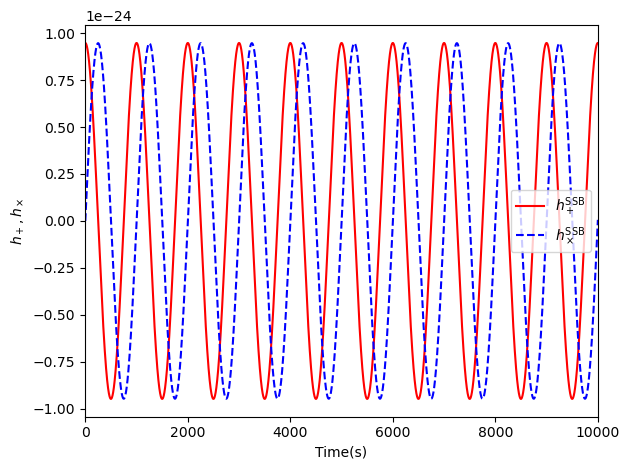

In [4]:
delta_t = 1.
tf = np.arange(0, GCBpars['T_obs'], delta_t)

GCBwf = waveforms['gcb'](**GCBpars)
hpssb, hcssb = GCBwf.get_hphc(tf)

plt.figure()
plt.plot(tf, hpssb, 'r-', label=r'$h_+^{\rm SSB}$')
plt.plot(tf, hcssb, 'b--', label=r'$h_\times^{\rm SSB}$')
plt.xlabel("Time(s)")
plt.ylabel(r"$h_+, h_\times$")
plt.xlim(0, 10000)  # let's zoom into a small range
plt.legend(loc="best")
plt.tight_layout()

In [5]:
def generate_td_data(pars, t_array, s_type='gcb', det='TQ', show_y_slr=False):
    print(f"Generating {s_type} waveforms")
    wf = waveforms[s_type](**pars)
    if show_y_slr:
        # Here is the example of how to check single arm response
        st = time.time()
        y_slr = get_y_slr_td(wf, t_array, det)
        ed = time.time()
        print(f"Time cost: {ed-st:.3f}s for {tf.shape[0]} points")

        tags = [(1, 2), (2, 1), (1, 3), (3, 1), (2, 3), (3, 2)]
        for i, tag in enumerate(tags):
            plt.figure()
            for j in range(4):
                plt.subplot(4, 1, j+1)
                plt.plot(tf, y_slr[tag][j])
                plt.title(f"y_{tag} [{j}]L")

    st = time.time()
    X, Y, Z = get_XYZ_td(wf, tf, det)
    A, E, T = tdi_XYZ2AET(X, Y, Z)
    # You can directly use get_AET_td() if you want AET channel only
    ed = time.time()
    print(f"Time cost of calculating XYZ and AET with y_slr: {ed-st:.3f}s")

    plt.subplots(2, 3, sharex='all', sharey='all')
    for i, (d, label) in enumerate(zip((X, Y, Z, A, E, T), "XYZAET")):
        plt.subplot(2, 3, i+1)
        plt.plot(tf[:-5], d[:-5])
        plt.xlabel("Time")
        plt.ylabel("h")
        plt.title(label)
    plt.tight_layout()

Generating gcb waveforms
Time cost of calculating XYZ and AET with y_slr: 5.134s


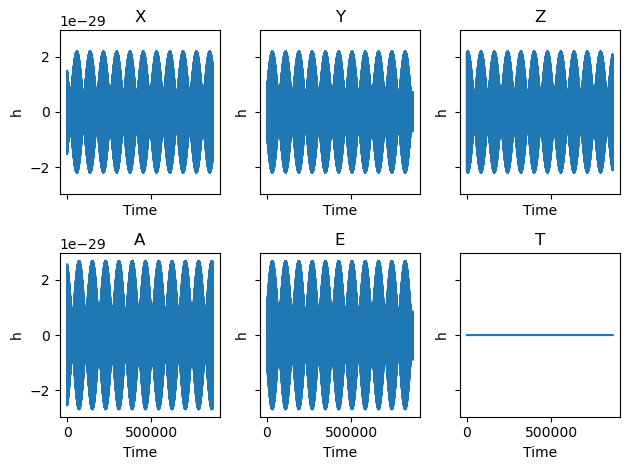

In [6]:
generate_td_data(GCBpars, tf, show_y_slr=False)

### FastGB: GCB waveform from fast/slow decomposition

GWSpace also adopt FastGB from `Galaxy` in the Mock LISA Data Challenge (MLDC). It uses a fast/slow decomposition of the waveform to reduce the computational cost, see arXiv:0704.1808 for more details.

Now take J0806 (Orientation of TianQin detector orbit) as an example:

In [7]:
def generate_fastgb(dt=1., oversample=1, show_td=False):
    # dt = 15.  # 1s for TianQin, 15s for LISA
    pars = {"mass1": 0.5,
            "mass2": 0.5,
            'T_obs': YRSID_SI*2,
            "phi0": 3.1716561,
            "f0": 0.00622028,
            "fdot": 7.48528554e-16,
            "psi": 2.91617795,
            "iota": 0.645772,
            "Lambda": 2.10225,  # ecliptic longitude [rad] J0806
            "Beta": -0.082205,  # ecliptic latitude [rad]
            }
    fastB = waveforms['gcb'](**pars)

    st = time.time()
    f, X, Y, Z = fastB.get_fastgb_fd_single(dt, oversample, detector='TianQin')
    ed = time.time()
    print(f"time cost is {ed-st}s")

    plt.figure()
    plt.loglog(f, np.abs(X), label='X')
    plt.loglog(f, np.abs(Y), label='Y')
    plt.loglog(f, np.abs(Z), label='Z')
    plt.xlim(0.00620, 0.00624)
    plt.tight_layout()

    if show_td:
        st = time.time()
        t, X, Y, Z = fastB.get_fastgb_td(dt, oversample, detector='TianQin')
        ed = time.time()
        print(f"time cost is {ed-st}s")

        plt.figure()
        plt.plot(t, X, label='X')
        plt.plot(t, Y, label='Y')
        plt.plot(t, Z, label='Z')
        plt.tight_layout()

time cost is 0.004590034484863281s


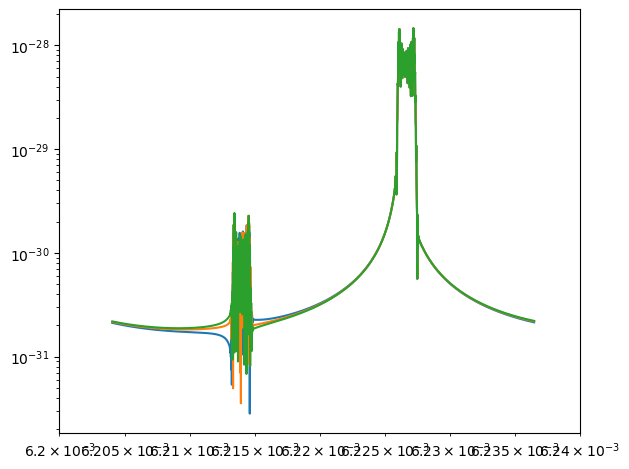

In [8]:
generate_fastgb()

## Extreme Mass Ratio Inspiral (EMRI)

GWSpace uses [FastEMRIWaveforms](https://github.com/BlackHolePerturbationToolkit/FastEMRIWaveforms) for EMRI. However, **you need to install it manually.**

In [9]:
EMRIpars = {'M': 1e6,  # Mass of larger black hole in solar masses
            'mu': 1e1,  # Mass of compact object in solar masses
            'a': 0.1,  # Dimensionless spin of massive black hole, will be ignored in Schwarzschild waveform
            'p0': 12.0,
            'e0': 0.2,
            'x0': 1.0,  # will be ignored in Schwarzschild waveform
            'qS': 0.3,  # polar sky angle
            'phiS': 0.3,  # azimuthal viewing angle
            'qK': 0.2,  # polar spin angle
            'phiK': 0.2,  # azimuthal viewing angle
            'dist': 1.0,  # Luminosity distance in Gpc
            'Phi_phi0': 1.0,
            'Phi_theta0': 2.0,
            'Phi_r0': 3.0,
            'psi': 0.4,
            'iota': 0.2,
            'T_obs': MONTH,
            }

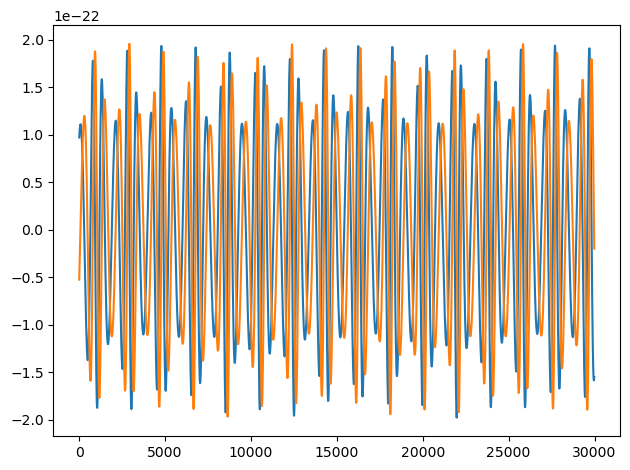

In [10]:
delta_t = 15.  # seconds
tf = np.arange(0, EMRIpars['T_obs'], delta_t)

EMRIwf = waveforms['emri'](**EMRIpars)
hp, hc = EMRIwf.get_hphc(tf)

index = 2000
plt.figure()
plt.plot(tf[:index], hp[:index])
plt.plot(tf[:index], hc[:index])
plt.tight_layout()

Generating emri waveforms
Time cost of calculating XYZ and AET with y_slr: 24.478s


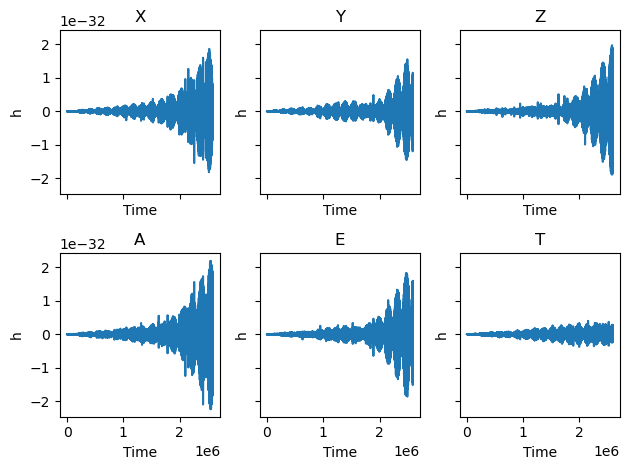

In [11]:
generate_td_data(EMRIpars, tf, s_type='emri')

## Binary Black Hole (BBH)

GWSpace supports two frequency-domain BBH waveform: IMRPhenomD and EccentricFD.


### IMRPhenomD

In [12]:
BHBpars = {"mass1": 3.5e6,
           "mass2": 2.1e5,
           'T_obs': MONTH*3,
           "chi1": 0.2,
           "chi2": 0.1,
           "DL": 1e3,
           "psi": 0.2,
           "iota": 0.3,
           "Lambda": 0.4,
           "Beta": 1.2,
           "tc": 0,
           }

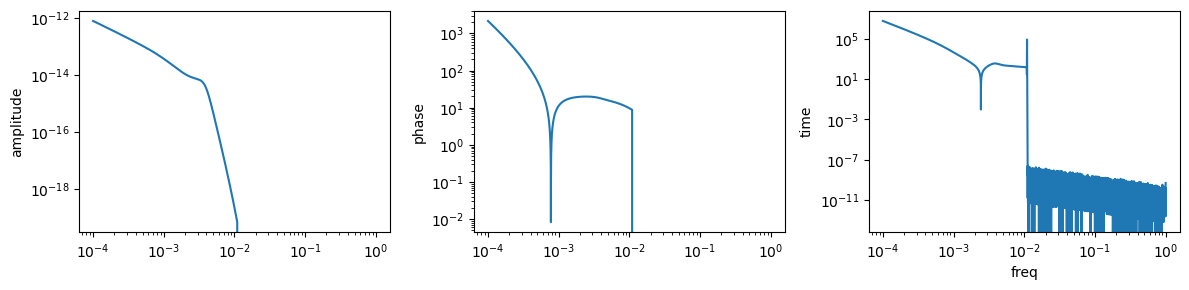

In [13]:
NF = 10240
freq = np.logspace(-4, 0, NF)

BHBwf = waveforms['bhb_PhenomD'](**BHBpars)
amp, phase, tf = BHBwf.get_amp_phase(freq)

plt.subplots(1, 3, sharex='all', figsize=(12, 3))
plt.subplot(1, 3, 1)
plt.loglog(freq, amp[(2, 2)])
plt.ylabel('amplitude')
plt.subplot(1, 3, 2)
plt.loglog(freq, np.abs(phase[(2, 2)]))
plt.ylabel('phase')
plt.subplot(1, 3, 3)
plt.loglog(freq, np.abs(tf[(2, 2)]))
plt.ylabel('time')
plt.xlabel('freq')
plt.tight_layout()

In [14]:
def generate_fd_data(pars, f_array, s_type='bhb_PhenomD', det='TQ', show_y_slr=False):
    print(f"Generating {s_type} waveforms")
    wf = waveforms[s_type](**pars)

    if show_y_slr:
        # Here is the example of how to check single arm response
        amp, phase, tf = wf.get_amp_phase(f_array)
        amp, phase, tf = amp[(2, 2)], phase[(2, 2)], tf[(2, 2)]
        h22 = amp * np.exp(1j*phase) * np.exp(2j*np.pi*f_array*wf.tc)
        det_orb = detectors[det](tf)

        st = time.time()
        y_slr = trans_y_slr_fd(wf.vec_k, wf.p_22, det_orb, f_array)[0]
        y_slr = {k: v*h22 for k, v in y_slr.items()}
        ed = time.time()
        print(f"Time cost for the fd response: {ed-st:.4f}s")

        ln = [(1, 2), (2, 1), (1, 3), (3, 1), (2, 3), (3, 2)]
        plt.figure()
        for ll in ln:
            plt.loglog(freq, np.abs(y_slr[ll]), label=ll)
        plt.legend()
        plt.tight_layout()

    X, Y, Z = wf.get_tdi_response(f_array, channel='XYZ', det=det)
    A, E, T = wf.get_tdi_response(f_array, channel='AET', det=det)

    plt.figure()
    plt.loglog(f_array, np.abs(X), '-', label='X')
    plt.loglog(f_array, np.abs(Y), '-', label='Y')
    plt.loglog(f_array, np.abs(Z), '-', label='Z')
    plt.loglog(f_array, np.abs(A), '--', label='A')
    plt.loglog(f_array, np.abs(E), '--', label='E')
    plt.loglog(f_array, np.abs(T), '--', label='T')
    plt.xlabel('f')
    plt.ylabel('h')
    plt.legend()
    plt.tight_layout()

Generating bhb_PhenomD waveforms
Time cost for the fd response: 0.7040s


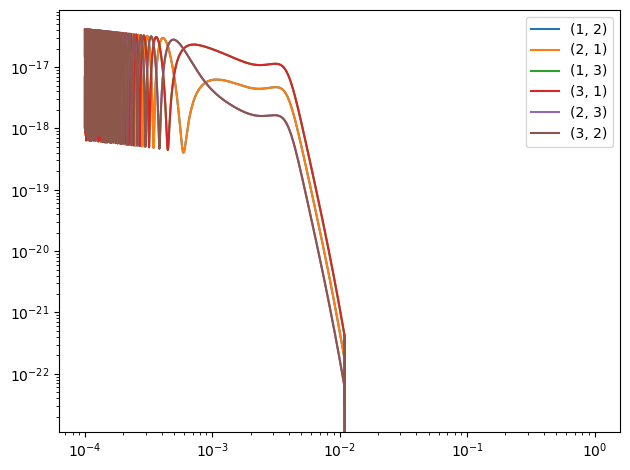

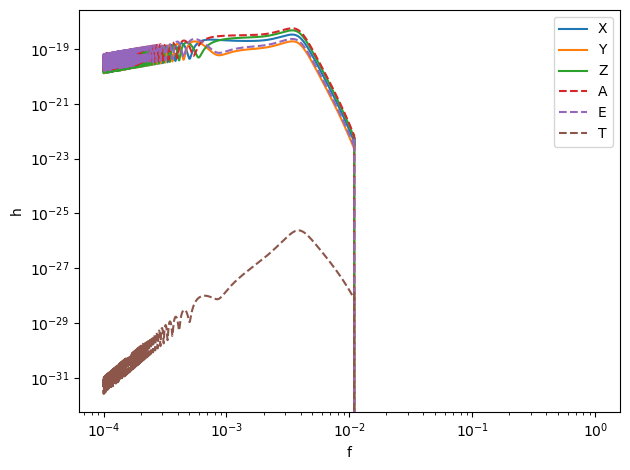

In [15]:
generate_fd_data(BHBpars, freq, show_y_slr=True)

### EccentricFD

GWSpace also supports a [modified version](https://github.com/HumphreyWang/pyEccentricFD) of EccentricFD waveform, which is specially for space-detector responses.

Since EccentricFD is an eccentric non-spinning inspiral-only waveform, it'd better be used for stellar-mass BBHs, which will merge outside the sensitive frequency band of space detectors.

In [16]:
ecc_par = {'DL': 100,  # Luminosity distance (Mpc)
           'mass1': 35.6,  # Primary mass (solar mass)
           'mass2': 30.6,  # Secondary mass(solar mass)
           'Lambda': 4.7,  # Longitude
           'Beta': -1.5,  # Latitude
           'phi_c': 0,  # Coalescence phase
           'T_obs': MONTH*3,  # Observation time (s)
           'tc': 0,  # Coalescence time (s)
           'iota': 0.3,  # Inclination angle
           'var_phi': 0,  # Observer phase
           'psi': 0.2,  # Polarization angle
           }  # masses of GW150914

Finished in  2.34419s 


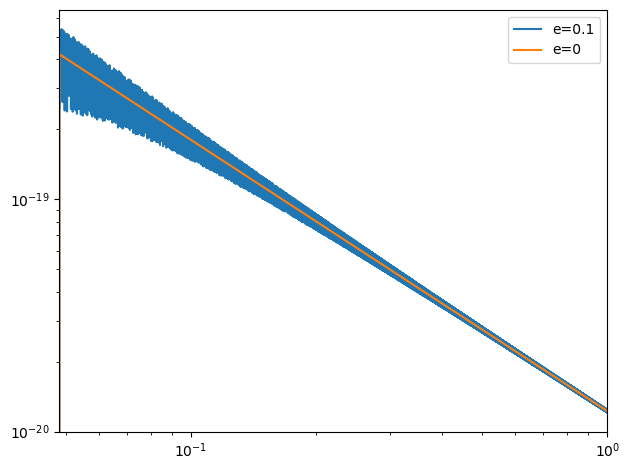

In [17]:
start_time = time.time()
delta_f = 1e-5
ecc_wf = waveforms['bhb_EccFD'](**ecc_par, eccentricity=0.1)
hp, _ = ecc_wf.get_ori_waveform(delta_f=delta_f, hphc=True)
ecc_wf0 = waveforms['bhb_EccFD'](**ecc_par, eccentricity=0.)
hp0, _ = ecc_wf0.get_ori_waveform(delta_f=delta_f, hphc=True)
print(f'Finished in {time.time() - start_time: .5f}s', '\n')

freq = delta_f * np.array(range(len(hp)))
plt.figure()
plt.loglog(freq, np.abs(hp), label='e=0.1')
plt.loglog(freq, np.abs(hp0), label='e=0')
plt.xlim(ecc_wf.f_min, 1)
plt.legend()
plt.tight_layout()

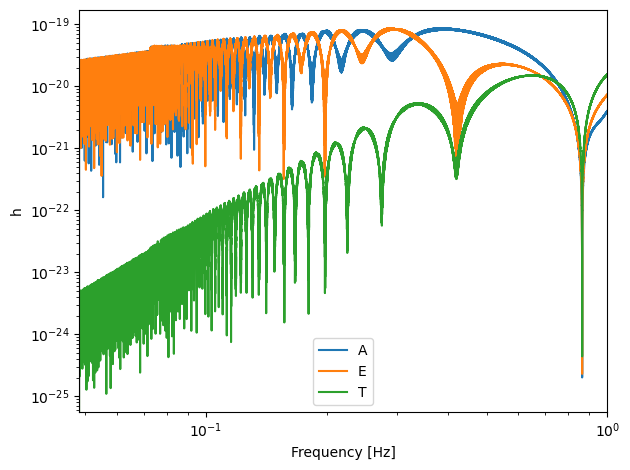

In [18]:
(smBBH_A, smBBH_E, smBBH_T), freq_e = ecc_wf.get_tdi_response(delta_f=delta_f, det='TQ')

plt.figure()
plt.loglog(freq_e, np.abs(smBBH_A), label='A')
plt.loglog(freq_e, np.abs(smBBH_E), label='E')
plt.loglog(freq_e, np.abs(smBBH_T), label='T')
plt.xlabel('Frequency [Hz]')
plt.ylabel('h')
plt.xlim(ecc_wf.f_min, 1)
# plt.ylim(1e-23, 1e-16)
plt.legend()
plt.tight_layout()

## GW Burst

GWSpace provides a sin-Gaussian waveform as basic model of bursts.

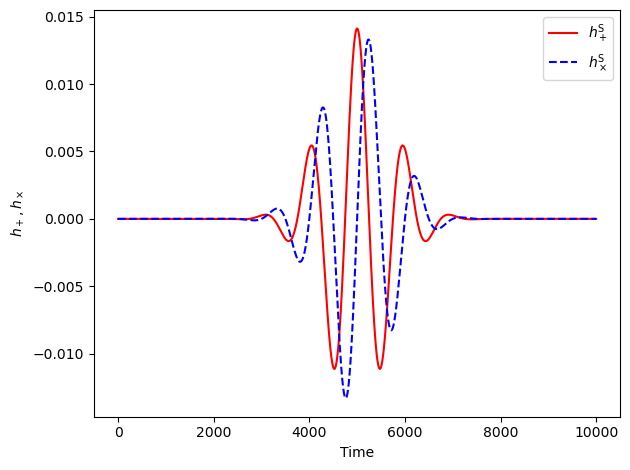

In [19]:
T_obs = 10000  # YRSID_SI / 4
delta_t = 1
tf = np.arange(0, T_obs, delta_t)

Burst = waveforms['burst'](amp=0.5, tau=1000, fc=0.001, tc=5000)
hp, hc = Burst.get_hphc(tf)

plt.figure()
plt.plot(tf, hp, 'r-', label=r'$h_+^{\rm S}$')
plt.plot(tf, hc, 'b--', label=r'$h_\times^{\rm S}$')
plt.xlabel("Time")
plt.ylabel(r"$h_+, h_\times$")
plt.legend()
plt.tight_layout()

# TODO: add results after response?

## Stochastic Gravitational Wave Background (SGWB)

GWSpace also supports isotropy SGWB and SGWB from a specific orientation.

Time cost: 77.06778979301453 s
1 year SNR for SGWB: 14.904593654795347


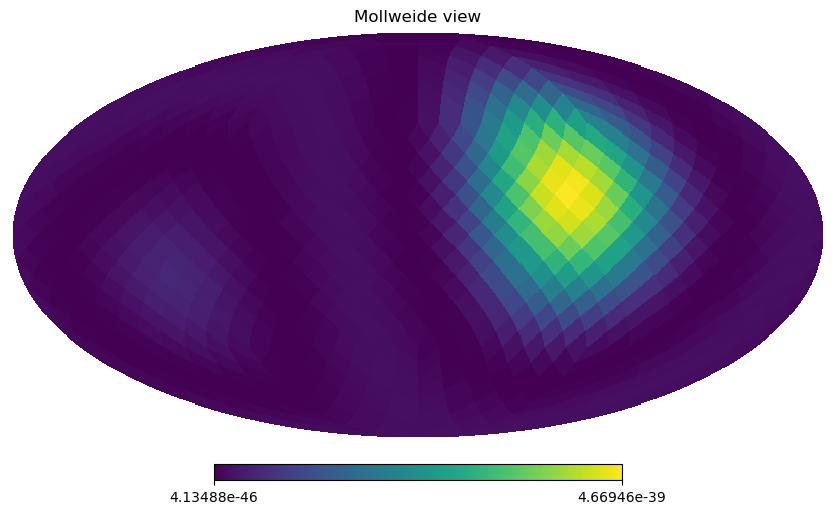

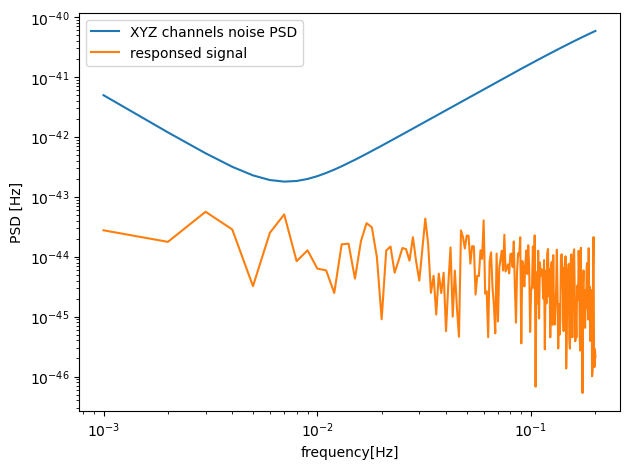

In [20]:
import healpy as hp
from gwspace.SGWB import SGWB
from gwspace.Noise import TianQinNoise

SGWBpars = {"nside": 8,
            "omega0": 5e-11,
            "alpha": 0.667,
            "T_obs": 63*5000,
            # "blm_vals": (1.0, 0.75, 0.5, 0.7j, 0.7-0.3j, 1.1j),
            # "blmax": 2,
            "theta": 1.3,
            "phi": 1.2,
            }
signal_pars = {"f_max": 0.2,
               "f_min": 0.001,
               "fn": 200,
               "t_segm": 5000,
               }
start_time = time.time()
SGWB_signal = SGWB(**SGWBpars)
res_signal, frange = SGWB_signal.get_response_signal(**signal_pars)
print(f"Time cost: {time.time()-start_time} s")

# We can first look at what the original signal looked like
signal_in_gu = SGWB_signal.get_ori_signal(frange)
hp.mollview(signal_in_gu[:, 0])

tq = TianQinNoise()
TX, TXY = tq.noise_XYZ(frange, unit="displacement")/(2e8*np.sqrt(3))**2

plt.figure()
plt.loglog(frange, TX, label="XYZ channels noise PSD")
plt.loglog(frange, np.abs(res_signal[:, 0, 0, 0]), label="responsed signal")
plt.xlabel('frequency[Hz]')
plt.ylabel('PSD [Hz]')
plt.legend()
plt.tight_layout()

# TODO: add descriptions
SNR = np.sqrt(24*3600*3.64*np.sum(res_signal[:, 0, 0, 0]**2/TX**2).real/frange.size)
print("1 year SNR for SGWB:", SNR)